In [1]:
from dolfin import *
import matplotlib.pyplot as plt
import time

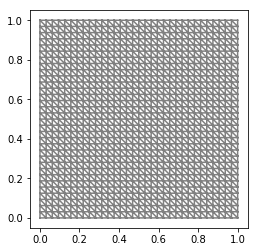

In [2]:
L = 3
N = 4*2**L
mesh = UnitSquareMesh(N, N, diagonal="left")
plot(mesh)

TR  = FiniteElement("RT", mesh.ufl_cell(), 1)
B3  = FiniteElement("Bubble", mesh.ufl_cell(), 3)
DG0 = VectorElement("DG", mesh.ufl_cell(), 0)
CG1 = FiniteElement("CG", mesh.ufl_cell(), 1)

PEERS = MixedElement([TR, B3, TR, B3, DG0, CG1])

In [3]:
class PeriodicBoundary(SubDomain):

    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
        # return True if on left or bottom boundary AND NOT on one of the two corners (0, 1) and (1, 0)
        return bool((near(x[0], 0) or near(x[1], 0)) and 
                (not ((near(x[0], 0) and near(x[1], 1)) or 
                        (near(x[0], 1) and near(x[1], 0)))) and on_boundary)

    def map(self, x, y):
        if near(x[0], 1) and near(x[1], 1):
            y[0] = x[0] - 1.
            y[1] = x[1] - 1.
        elif near(x[0], 1):
            y[0] = x[0] - 1.
            y[1] = x[1]
        else:   # near(x[1], 1)
            y[0] = x[0]
            y[1] = x[1] - 1.

In [4]:
PBC=PeriodicBoundary()
W = FunctionSpace(mesh, PEERS, constrained_domain=PBC)

(a1, b1, a2, b2, u, eta) = TrialFunctions(W)
(a1t, b1t, a2t, b2t, ut, etat) = TestFunctions(W)

In [5]:
sigma = as_tensor((a1,a2))+as_tensor([[b1.dx(1),-b1.dx(0)],[b2.dx(1),-b2.dx(0)]])  #in 2D
tau = as_tensor((a1t,a2t))+as_tensor([[b1t.dx(1),-b1t.dx(0)],[b2t.dx(1),-b2t.dx(0)]])  #in 2D

#asSigma = sigma-sigma.T
#asTau = tau-tau.T

In [6]:
I = Identity(2)
sample = 1

In [7]:
mu =  Expression('exp(m*(sin(2*pi*x[0])+cos(2*pi*x[1])))', degree=1, m = 0.0)
lda = Expression('exp(m*(cos(2*pi*x[0])+sin(2*pi*x[1])))', degree=1, m = 0.0)

mu.m = sample
lda.m = sample

f1 = Expression("20*sin(2*pi*x[0])", degree=1)
f2 = Expression("20*sin(2*pi*x[1])", degree=1)

In [8]:
a = (inner(1/2/mu*sigma+(1/(4*lda+4*mu)-1/4/mu)*tr(sigma)*I, tau)  \
    + inner(div(tau), u) + (tau[0,1]-tau[1,0])*eta \
    + inner(div(sigma), ut) + (sigma[0,1]-sigma[1,0])*etat)*dx

In [9]:
L = (-f1*ut[0]-f2*ut[1])*dx

In [10]:
w = Function(W)
solve(a == L, w, solver_parameters={'linear_solver': 'minres', 
                                    'preconditioner': 'jacobi'})

In [11]:
(ss1, sb1, ss2, sb2, su, seta) = w.split()

In [12]:
sst = as_tensor((ss1,ss2))+as_tensor([[sb1.dx(1),-sb1.dx(0)],[sb2.dx(1),-sb2.dx(0)]])  #in 2D

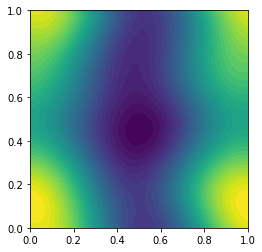

In [13]:
plt.figure()
plot(sst[0,0])

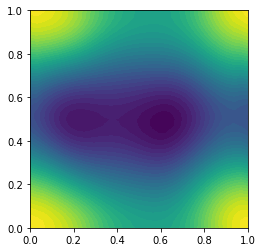

In [14]:
plt.figure()
plot(sst[1,1])

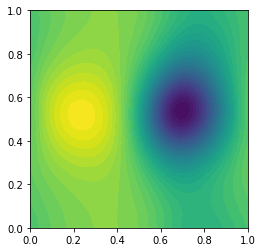

In [15]:
plt.figure()
plot(su[0])

In [16]:
x = SpatialCoordinate(mesh)
obs = assemble((x[1]**0.5*sst[0,0]+x[0]**0.5*sst[1,1])*dx)
print(obs)

1.3222915912072564
